# State space model

torch.Size([100, 2])
torch.Size([100, 2])


<Axes: title={'center': 'custom linear gaussian state space model'}>

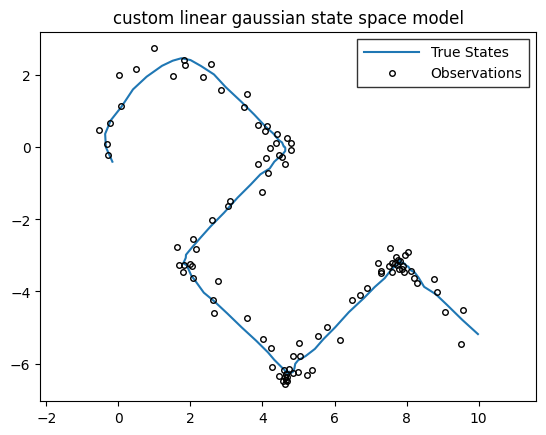

In [2]:
import torch
from torch import nn 
from torch.distributions.multivariate_normal import MultivariateNormal
from matplotlib import pyplot as plt

class ParamsLGSSM :

    class CreateOrPredict:
        Create = 0,
        Predict = 1

    class ParamsPzInitSSM:
        def __init__(self,pz_init_mean,pz_init_cov):
            self.pz_init_mean = pz_init_mean
            self.pz_init_cov = pz_init_cov
    
    class ParamsDynamicFunctions:
        def __init__(self,f,h):
            self.f = f
            self.h = h

    class ParamsGaussianNoise:
        def __init__(self,q_t_cov,r_t_cov):
            self.q_t_cov = q_t_cov
            self.r_t_cov = r_t_cov
    
    class ParamsZt:
        def __init__(self,F_t,B_t,b_t):
            self.F_t = F_t
            self.B_t = B_t
            self.b_t = b_t
    
    class ParamsYt:
        def __init__(self,H_t,D_t,d_t):
            self.H_t = H_t
            self.D_t = D_t
            self.d_t = d_t

    def __init__(self, z_dim:int, y_dim:int,
                 paramsPzInitSSM: ParamsPzInitSSM,
                 paramsGaussianNoise: ParamsGaussianNoise,
                 paramsDynamicFunctions: ParamsDynamicFunctions = None,
                 creationOrPrediction: CreateOrPredict = CreateOrPredict.Create,
                 paramsZt:ParamsZt=None,
                 paramsYt:ParamsYt=None):
        self.paramsPzInitSSM = paramsPzInitSSM
        self.paramsDynamicFunctions = paramsDynamicFunctions
        self.paramsGaussianNoise = paramsGaussianNoise
        self.paramsZt = paramsZt
        self.paramsYt = paramsYt
        self.z_dim = z_dim
        self.y_dim = y_dim

class LGSSM :

    def __init__(self, paramsLGSSM: ParamsLGSSM):
        self.pz_init_mean = paramsLGSSM.paramsPzInitSSM.pz_init_mean
        self.pz_init_cov = paramsLGSSM.paramsPzInitSSM.pz_init_cov
        self.f = paramsLGSSM.paramsDynamicFunctions.f
        self.q_t_cov = paramsLGSSM.paramsGaussianNoise.q_t_cov
        self.h = paramsLGSSM.paramsDynamicFunctions.h
        self.r_t_cov = paramsLGSSM.paramsGaussianNoise.r_t_cov
        self.z_dim = paramsLGSSM.z_dim
        self.y_dim = paramsLGSSM.y_dim

    def prob_fn(self,mean: torch.Tensor,cov: torch.Tensor):
        return MultivariateNormal(mean,cov)
    
    def init_samples(self):
        z0 = self.prob_fn(self.pz_init_mean,self.pz_init_cov).sample()
        y0 = self.prob_fn(self.h(z0),self.r_t_cov).sample()
        return z0, y0
    
    def next_step(self, prev_step=None,init=False):
        if init:
            return self.init_samples() 
        else:
            zt = self.prob_fn(self.f(prev_step),self.q_t_cov).sample()
            yt = self.prob_fn(self.h(zt),self.r_t_cov).sample()
            return zt, yt
    
    def execute(self,steps:int):
        zt = torch.zeros(steps,self.z_dim)
        yt = torch.zeros(steps,self.y_dim)
        for i in range(steps):
            if i==0:
                zt[i],yt[i] = self.next_step(init=True)
            else:
                zt[i],yt[i] = self.next_step(zt[i-1])
        return zt,yt

def params_lg_ssm_create():
    z_dim = 2
    y_dim = 2
    pz_init_mean = torch.tensor([1.5,0.0])
    pz_init_cov = torch.eye(z_dim)
    f = lambda z: z+0.4*torch.tensor([torch.sin(z[1]),torch.cos(z[0])])
    q_t_cov = torch.eye(z_dim)*0.001
    h = lambda z: z
    r_t_cov = torch.eye(y_dim)*0.05
    return ParamsLGSSM(paramsDynamicFunctions=ParamsLGSSM.ParamsDynamicFunctions(f,h),
                       paramsPzInitSSM=ParamsLGSSM.ParamsPzInitSSM(pz_init_mean,pz_init_cov),
                       paramsGaussianNoise=ParamsLGSSM.ParamsGaussianNoise(q_t_cov,r_t_cov),
                       z_dim=z_dim,y_dim=y_dim)

model = LGSSM(params_lg_ssm_create())
zt,yt = model.execute(100)
print(zt.shape)
print(yt.shape)

def plot_inference(states, emissions, estimates=None, est_type="", ax=None, title="", aspect=0.8, show_states=True):
    if ax is None:
        fig, ax = plt.subplots()
    if show_states:
        ax.plot(*states.T, label="True States")
    ax.plot(*emissions.T, "ok", fillstyle="none", ms=4, label="Observations")
    if estimates is not None:
        ax.plot(*estimates.T, color="r", linewidth=1.5, label=f"{est_type} Estimate")
    #ax.set_aspect(aspect)
    ax.set_title(title)
    ax.legend(borderpad=0.5, handlelength=4, fancybox=False, edgecolor="k")
    ax.axis('equal')
    return ax
plot_inference(zt,yt,title='custom linear gaussian state space model')

$$
p(z_t|z_{t-1},u_t) = N(z_t|F_tz_{t-1}+B_tu_t+b_t,Q_t)
$$
$$
p(y_t|z_t,u_t) = N(y_t|H_tz_t+D_tu_t+d_t,R_t)
$$
Here, 

$z_t$ is the hidden state at t step

$z_{t-1}$ is the hidden state at t-1 step

$u_t$ is the inputs (However we conside inputs as zero here)

$F_t, H_t$ are the weight associated with the $z_{t-1}$ hidden state and $z_t$ respectively

$B_t, D_t$ are the input weight associated with input $u_t$

$b_t, d_t$ are the biases

$Q_t$ is the additive gaussian noise associated with $z_t$, we consider this as covariance in $N(0,Q_t)$ gaussian and use this value in $p(z_t|z_{t-1},u_t)$

$R_t$ is the additive gaussian noise associated with $y_t$, we consider this as covariance in $N(0,R_t)$ gaussian and use this value in $p(y_t|z_t,u_t)$

In [18]:
class kalman_filter:

    def __init__(self, z_dim):
        self.z_dim = z_dim
        self.parameters = self.params_init_kalman()
    
    # using defaults values in calculation comments
    def params_init_kalman(self, z_dim = 2,y_dim = 2):
        # random samples for generating samples
        random_z_mean_sample = torch.rand(z_dim)
        random_z_matrix_sample = torch.rand(z_dim,z_dim)
        random_y_mean_sample = torch.rand(y_dim)
        random_y_matrix_sample = torch.rand(y_dim,y_dim)

        sample_uniform = lambda sample_tensor=torch.rand(1),low=0,high=1 : torch.distributions.Uniform(low,high).sample(sample_tensor.size())
        sample_normal = lambda x : (1/torch.sqrt(torch.tensor([2])*torch.pi))*torch.exp(-0.5*torch.square(x))

        pz_init_mean = sample_normal(sample_uniform(random_z_mean_sample))
        pz_init_cov = torch.eye(z_dim) * sample_uniform(random_z_matrix_sample)
        # f_t is 2x2 when combined with z sample(2x1) results in 2x1 value
        F_t = sample_normal(sample_uniform(random_z_matrix_sample))
        # F_t = jacfwd(lambda z: z+0.4*(torch.sin(z[1]),torch.cos(z[0])))
        B_t = sample_normal(sample_uniform(random_z_matrix_sample))
        # b_t is bias of 2x1 
        b_t = sample_normal(sample_uniform(random_z_mean_sample))
        # H_t is 2x2 when combined with z sample(2x1) results in 2x1 value
        H_t = sample_normal(sample_uniform(random_y_matrix_sample))
        # H_t = jacfwd(lambda z:z)
        D_t = sample_normal(sample_uniform(random_y_matrix_sample))
        # d_t is bias of 2x1 
        d_t = sample_normal(sample_uniform(random_z_mean_sample))
        # Q_t_cov is the gaussian noise covariance
        Q_t_cov = torch.eye(z_dim) * sample_uniform(random_z_matrix_sample)
        # R_t_cov is the gaussian noise covariance
        R_t_cov = torch.eye(y_dim) * sample_uniform(random_y_matrix_sample)
        return ParamsLGSSM(z_dim,y_dim,paramsPzInitSSM=ParamsLGSSM.ParamsPzInitSSM(pz_init_mean,pz_init_cov),
                        paramsGaussianNoise=ParamsLGSSM.ParamsGaussianNoise(Q_t_cov,R_t_cov),
                        paramsYt=ParamsLGSSM.ParamsYt(H_t,D_t,d_t),
                        paramsZt=ParamsLGSSM.ParamsZt(F_t,B_t,b_t),
                        creationOrPrediction=ParamsLGSSM.CreateOrPredict.Predict)
    
    def _predict(self,m, S, F, Q):
        mu_pred = torch.matmul(F,m)
        # mu_pred = F @ m + B @ u + b
        # Sigma_pred = F @ S @ F.T + Q
        Sigma_pred = torch.matmul(torch.matmul(F,S),F.T) + Q
        return mu_pred, Sigma_pred

    def _log_likelihood(self, pred_mean, pred_cov, H, R, y):
        m = torch.matmul(H,pred_mean)
        S = R + torch.matmul(torch.matmul(H,pred_cov),H.T)
        return torch.distributions.MultivariateNormal(m, S).log_prob(y)
        
    def _condition_on(self, m, P, H, R, y):
        S = R + H @ P @ H.T
        K = self.psd_solve(S, torch.matmul(H,P))
        cov = P - torch.matmul(torch.matmul(K,S),K.T)
        mu_cond = m + torch.matmul(K,y - torch.matmul(H,m))
        return mu_cond, self.symmetrize(cov)
    
    # def gauss_moments(self,mean,cov,coeff,additive_covs,dim,input=None,bias=None):
    #     posterior_mean = torch.matmul(coeff,mean)
    #     posterior_cov = additive_covs + torch.matmul(torch.matmul(coeff,cov),coeff.T)
    #     return posterior_mean,posterior_cov

    def symmetrize(self,A):
        return 0.5 * (A + torch.swapaxes(A, -1, -2))

    def psd_solve(self,A, b, diagonal_boost=1e-9):
        A = self.symmetrize(A) + diagonal_boost * torch.eye(A.shape[-1])
        L = torch.linalg.cholesky(A)
        x = torch.cholesky_solve(L, b)
        return x

    # Linear equation solver (KS = T)
    # def solve_k(self,S,C):
    #     L = torch.linalg.cholesky(S)
    #     return torch.cholesky_solve(C,L)

    # \cap y_t -> yte
    def gauss_conditions(self,mean,cov,H_t,R_t,y):
        yte = torch.matmul(H_t,mean)
        C_t = torch.matmul(cov,H_t)
        S_t = R_t + torch.matmul(torch.matmul(H_t,cov),H_t.T)
        K_t = self.solve_k(S_t,C_t)
        output_mean = mean + torch.matmul(K_t,(y-yte))
        output_cov = cov - torch.matmul(torch.matmul(K_t,S_t),K_t.T)
        return output_mean,output_cov
    
    def execute(self,yt):
        self.y_dim = yt.shape[1]
        self.total_steps = yt.shape[0]
        yt_pred = torch.zeros(yt.shape)
        result = torch.zeros(yt.shape)
        for i in range(self.total_steps):
            if i==0:
                z_mean = self.parameters.paramsPzInitSSM.pz_init_mean
                z_cov = self.parameters.paramsPzInitSSM.pz_init_cov

            H_t = self.parameters.paramsYt.H_t
            R_t = self.parameters.paramsGaussianNoise.r_t_cov
            # prior used to create likelihood
            # y_mean,y_cov = self.gauss_moments(z_mean,z_cov,H_t,R_t,self.y_dim)
            likelihood = self._log_likelihood(z_mean,z_cov,H_t,R_t,yt[i])
            # filtered mean & covariance
            # y_mean_post, y_cov_post = self.gauss_conditions(z_mean,z_cov,H_t,R_t,yt[i])
            y_mean_post, y_cov_post = self._condition_on(z_mean,z_cov,H_t,R_t,yt[i])
            # posterior mean & covariance
            F_t = self.parameters.paramsZt.F_t
            Q_t = self.parameters.paramsGaussianNoise.q_t_cov
            z_mean,z_cov = self._predict(y_mean_post,y_cov_post,F_t,Q_t)
            # convert posterior to prior
            z_mean = y_mean_post
            z_cov = y_cov_post
            result[i] = y_mean_post
        return result
    
filter_preditions = kalman_filter(z_dim=2)

y_mean_post = filter_preditions.execute(yt)
# print(log_probs)
plot_inference(zt,yt,y_mean_post,title='custom linear gaussian state space model')

ValueError: Expected parameter covariance_matrix (Tensor of shape (2, 2)) of distribution MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2])) to satisfy the constraint PositiveDefinite(), but found invalid values:
tensor([[-275704.9062, -187406.1562],
        [-187406.1719, -127386.9297]])

$$
p(z_{t+1}) = \int N(z_t | m, S) N(z_{t+1} | f(z_t, u), Q)
                    = N(z_{t+1} | f(m, u), F(m, u) S F(m, u)^T + Q)
                    $$

In [5]:
def symmetrize(A):
    """Symmetrize one or more matrices."""
    return 0.5 * (A + torch.swapaxes(A, -1, -2))

cov = torch.randn(3,3)
print(cov)
print(torch.swapaxes(cov, -1, -2))
print(symmetrize(cov))



def psd_solve(A, b, diagonal_boost=1e-9):
    """A wrapper for coordinating the linalg solvers used in the library for psd matrices."""
    A = symmetrize(A) + diagonal_boost * torch.eye(A.shape[-1])
    L, lower = cho_factor(A, lower=True)
    x = cho_solve((L, lower), bn)
    return x

tensor([[-0.0236, -0.3588,  1.2250],
        [ 0.3504, -0.4645, -0.2037],
        [-0.7621,  0.2143, -0.1025]])
tensor([[-0.0236,  0.3504, -0.7621],
        [-0.3588, -0.4645,  0.2143],
        [ 1.2250, -0.2037, -0.1025]])
tensor([[-0.0236, -0.0042,  0.2315],
        [-0.0042, -0.4645,  0.0053],
        [ 0.2315,  0.0053, -0.1025]])


In [ ]:
class kalman_filter:

    def __init__(self, z_dim):
        self.z_dim = z_dim
        self.parameters = self.params_init_kalman()
    
    # using defaults values in calculation comments
    def params_init_kalman(self, z_dim = 2,y_dim = 2):
        # intial values used in calculation
        pz_init_mean = torch.randn(z_dim)
        pz_init_cov = torch.eye(z_dim) * 0.05
        # f_t is 2x2 when combined with z sample(2x1) results in 2x1 value
        F_t = torch.randn(z_dim,z_dim)
        # B_t is dimension depends on u_t dimension so ',' is used
        B_t = torch.randn(z_dim,)
        # b_t is bias of 2x1 
        b_t = torch.randn(z_dim)
        # H_t is 2x2 when combined with z sample(2x1) results in 2x1 value
        H_t = torch.randn(y_dim,y_dim)
        # D_t is dimension depends on u_t dimension so ',' is used
        D_t = torch.randn(z_dim,)
        # d_t is bias of 2x1 
        d_t = torch.randn(z_dim)
        # Q_t_cov is the gaussian noise covariance
        Q_t_cov = torch.eye(z_dim) * 0.05
        # R_t_cov is the gaussian noise covariance
        R_t_cov = torch.eye(y_dim) * 0.05
        return ParamsLGSSM(z_dim,y_dim,paramsPzInitSSM=ParamsLGSSM.ParamsPzInitSSM(pz_init_mean,pz_init_cov),
                        paramsGaussianNoise=ParamsLGSSM.ParamsGaussianNoise(Q_t_cov,R_t_cov),
                        paramsYt=ParamsLGSSM.ParamsYt(H_t,D_t,d_t),
                        paramsZt=ParamsLGSSM.ParamsZt(F_t,B_t,b_t),
                        creationOrPrediction=ParamsLGSSM.CreateOrPredict.Predict)
    
    def gauss_moments(self,mean,cov,weight,additive_covs,dim,input=None,bias=None):
        # output_mean = torch.matmul(weight,mean) + bias if bias else torch.zeros(dim)
        print('gauss_moments',mean,weight)
        output_mean = torch.matmul(weight,mean)
        print('mean',output_mean)
        S = additive_covs + torch.matmul(torch.matmul(weight,cov),weight.T)
        print('S',S)
        C = torch.matmul(cov,weight.T)
        print('C',C)
        return output_mean,S,C

    def symmetrize(self,A):
        return 0.5 * (A + torch.swapaxes(A, -1, -2))
    
    def diagonal_boost(self,cov,diagonal_boost=1e-9):
        return self.symmetrize(cov) + diagonal_boost * torch.eye(cov.shape[-1])

    # Linear equation solver (KS = T)
    def solve_k(self,S,C):
        
        L = torch.linalg.cholesky(S)
        return torch.cholesky_solve(C,L)

    # \cap y_t -> yte
    def gauss_conditions(self,mean,cov,yte,S,C,y):
        # K = torch.matmul(C,torch.inverse(S))
        # K = torch.linalg.lstsq(S.T,C.T)[0].T
        # print(S)
        K = self.solve_k(S,C)
        output_mean = mean + torch.matmul(K,(y-yte))
        output_cov = cov - torch.matmul(torch.matmul(K,S),K.T)
        
        l = torch.distributions.MultivariateNormal(yte,S) 
        return output_mean,output_cov,l.log_prob(y)
    
    def execute(self,yt):
        self.y_dim = yt.shape[1]
        self.total_steps = yt.shape[0]
        yt_pred = torch.zeros(yt.shape)
        log_probs = torch.zeros(yt.shape)
        for i in range(self.total_steps):
            if i==0:
                c_mean = self.parameters.paramsPzInitSSM.pz_init_mean
                c_cov = self.parameters.paramsPzInitSSM.pz_init_cov
            
            F_t = self.parameters.paramsZt.F_t
            Q_t = self.parameters.paramsGaussianNoise.q_t_cov
            z_mean,z_cov,_ = self.gauss_moments(c_mean,c_cov,F_t,Q_t,self.z_dim)
            # print(z_cov)
            H_t = self.parameters.paramsYt.H_t
            R_t = self.parameters.paramsGaussianNoise.r_t_cov
            y_mean,S,C = self.gauss_moments(z_mean,z_cov,H_t,R_t,self.y_dim)
            # print(S)
            # using H_t & R_t
            # K = torch.matmul(torch.matmul(c_cov,H_t.T),torch.inverse(R_t))

            c_mean_next, c_cov_next, likelihood = self.gauss_conditions(z_mean,z_cov,y_mean,S,C,yt[i])
            c_mean = c_mean_next
            c_cov = self.symmetrize(c_cov_next)
            log_probs[i] = likelihood
            break
        # print(log_probs)
        return yt_pred,log_probs
    


filter_preditions = kalman_filter(z_dim=2)
yt_pred,log_probs = filter_preditions.execute(yt)
# print(log_probs)
# plot_inference(zt,yt,log_probs,title='custom linear gaussian state space model')